<a href="https://colab.research.google.com/github/jnokorie/Stock-Prediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.5712643678160919

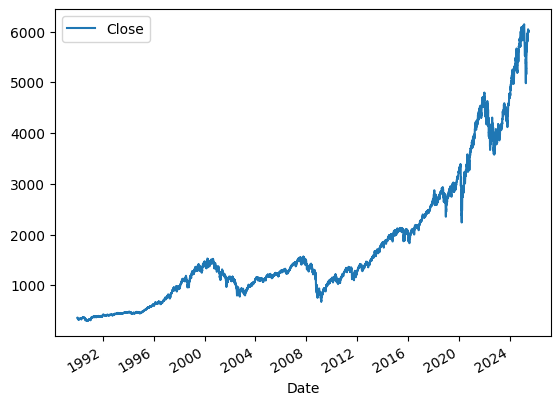

In [ ]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period = 'max')
sp500

sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
sp500 = sp500.loc['1990-01-01':].copy()
sp500.plot.line(y='Close')
sp500

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f'Close_Ratio_{horizon}'
  sp500[ratio_column] = sp500['Close']/rolling_averages['Close']

  trend_column = f'Trend_{horizon}'
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]
sp500 = sp500.dropna()

model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state=1)

def predict (train, test, predictors, model):
  model.fit(train[predictors], train['Target'] )
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds>= 0.6] = 1
  preds[preds < 0.6] = 0
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'],preds], axis = 1 )
  return combined

all_predictions = []

def backtest(data, model, predictors, start = 2500, step = 250):

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

predictions = backtest(sp500, model, new_predictors)
predictions['Predictions'].value_counts()

precision_score(predictions['Target'], predictions['Predictions'])

In [ ]:
def predict_tomorrow(data, model, predictors):
    # Get the most recent row (latest day) as the test set
    test = data.iloc[-1:].copy()  # Last row for the latest data
    train = data.iloc[:-1].copy()  # Everything except the last row for training

    # Fit the model on the training data
    model.fit(train[predictors], train['Target'])

    # Predict for tomorrow (the last row in the test set)
    preds = model.predict_proba(test[predictors])[:, 1]  # Get probabilities
    preds = 1 if preds >= 0.5 else 0  # Apply the threshold of 0.6

    # Output the prediction
    if preds == 1:
        return "The market will go up tomorrow."
    else:
        return "The market will go down tomorrow."

# Call the function to predict tomorrow's market direction
print(predict_tomorrow(sp500, model, new_predictors))


The market will go up tomorrow.


In [ ]:
final = pd.concat(all_predictions)
(final)
#(sp500)


,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2025-06-11 00:00:00-04:00,1,0.0
2025-06-12 00:00:00-04:00,0,0.0
2025-06-13 00:00:00-04:00,1,0.0
